In [21]:
%matplotlib widget
from generate_chunks import load_data
from train_models import ModelTrainer
from failure_detection import print_failures, simple_lowpass_filter
import matplotlib.pyplot as plt
import numpy as np

model = ModelTrainer(f'configs/PT3_TCN.json').fit()
train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=model.version, scaler=model.scaler)
val_size = int(0.3 * len(train_chunks))
train_errors = model.calc_loss(train_chunks[-val_size:], train_chunks[-val_size:], average=False).mean(axis=(1,2))
training_chunk_dates = training_chunk_dates[-val_size:]
#train_errors = model.calc_loss(train_chunks, train_chunks, average=False).mean(axis=(1,2))
test_errors_raw = model.calc_loss(test_chunks, test_chunks, average=False)
test_errors = test_errors_raw.mean(axis=(1,2))


0.035810899129137395
[2020-04-18 01:13:52, 2020-04-19 03:01:57]
[2020-05-13 14:22:24, 2020-05-14 05:19:58]
[2020-05-19 23:05:44, 2020-05-21 05:57:13]
[2020-05-30 00:02:40, 2020-05-30 06:39:13]
[2020-06-05 10:32:37, 2020-06-08 14:35:18]


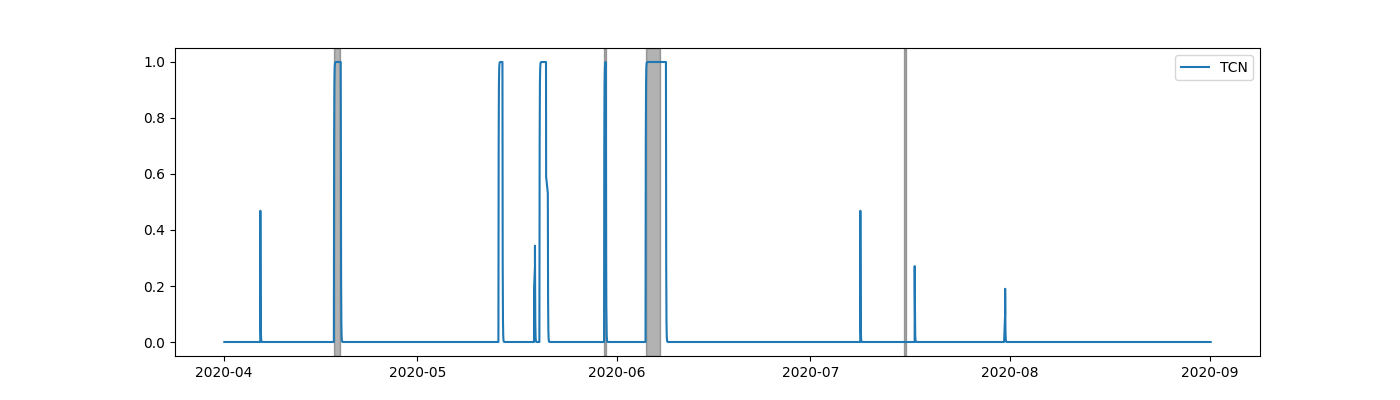

In [26]:
#anom = extreme_anomaly(train_errors)
def find_continuous_ranges(arr):
    # Sort the array
    arr = np.sort(arr)
    # Find the gaps in the sorted array
    gaps = np.diff(arr) != 1
    # Get the indices where the gaps are present
    gap_indices = np.where(gaps)[0]
    if len(gap_indices) == 0:
        return []
    # Generate the boundaries of the ranges
    boundaries = np.split(arr, gap_indices + 1)
    # Convert boundaries to list of tuples
    ranges = [(int(sub_arr[0]), int(sub_arr[-1])) for sub_arr in boundaries]
    return ranges

anom = np.quantile(train_errors, q=0.99)*10
alpha = 0.1
print(anom)

use_channels = np.arange(len(model.use_channels))

binary_output = (test_errors_raw[..., use_channels].mean(axis=(1, 2)) > anom).astype(np.int8)
output = simple_lowpass_filter(binary_output, alpha)
failures = (output > 0.5).astype(np.int8)
print_failures(test_chunk_dates, failures)

feature_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP']

plt.figure(figsize=(14, 4))

actual_failures = [
    (np.datetime64('2020-04-18T00:00:00'), np.datetime64('2020-04-18T23:59:00')),
    (np.datetime64('2020-05-29T23:30:00'), np.datetime64('2020-05-30T06:00:00')),
    (np.datetime64('2020-06-05T10:00:00'), np.datetime64('2020-06-07T14:30:00')),
    (np.datetime64('2020-07-15T14:30:00'), np.datetime64('2020-07-15T19:00:00')),
]

lps_signals = [
    np.datetime64('2020-07-15T14:30:00'), 
    np.datetime64('2020-07-15T14:30:00'), 
    np.datetime64('2020-07-15T14:30:00'), 
    np.datetime64('2020-07-15T14:30:00'), 
]

for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)


#plt.plot(test_chunk_dates[:, 1], test_errors_raw[..., use_channels].mean(axis=(1,2)), label='TCN')
plt.plot(test_chunk_dates[:, 1], output, label='TCN')
# for channel_idx in use_channels:
#     plt.plot(test_chunk_dates[:, 1], test_errors_raw[..., channel_idx].mean(axis=-1), label=feature_names[channel_idx])

plt.legend()
plt.show()

# Investigate error distribution(s)

test 2930 2933
test 3763 3905
test 4542 4738
test 12275 12683
test 16287 16425
test 18945 19544
test 25479 25554
test 25666 25710


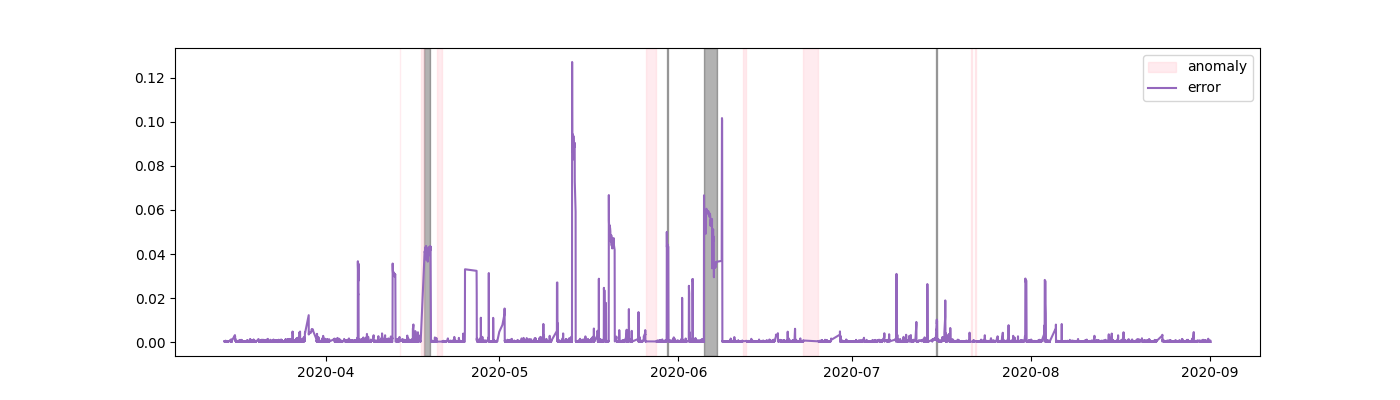

In [13]:
def find_continuous_ranges(arr):
    # Sort the array
    arr = np.sort(arr)
    # Find the gaps in the sorted array
    gaps = np.diff(arr) != 1
    # Get the indices where the gaps are present
    gap_indices = np.where(gaps)[0]
    if len(gap_indices) == 0:
        return []
    # Generate the boundaries of the ranges
    boundaries = np.split(arr, gap_indices + 1)
    # Convert boundaries to list of tuples
    ranges = [(int(sub_arr[0]), int(sub_arr[-1])) for sub_arr in boundaries]
    return ranges

plt.figure(figsize=(14, 4))

for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

# Train
t = train_chunks[..., [0, 1, 2, 3, 4, 5, 6]]
anomalous = np.all((t.std(axis=1) < 0.01), axis=1)
anomalous_idx = np.where(anomalous)[0]

anomaly_ranges = find_continuous_ranges(anomalous_idx)
for idx, (b, e) in enumerate(anomaly_ranges):
    print('train', b, e)
    plt.axvspan(training_chunk_dates[b, 1], training_chunk_dates[e, 1], color='pink', alpha=0.3, label='anomaly' if idx == 0 else '')

# Test
t = test_chunks[..., [0, 1, 2, 3, 4, 5, 6]]
anomalous = np.all((t.std(axis=1) < 0.01), axis=1)
anomalous_idx = np.where(anomalous)[0]

anomaly_ranges = find_continuous_ranges(anomalous_idx)
for idx, (b, e) in enumerate(anomaly_ranges):
    print('test', b, e)
    plt.axvspan(test_chunk_dates[b, 1], test_chunk_dates[e, 1], color='pink', alpha=0.3, label='anomaly' if idx == 0 else '')

to_delete = []
padding = 10 
for (b, e) in anomaly_ranges:
    to_delete.append(np.arange(b-padding, e+padding+2))
to_delete = np.concatenate(to_delete)
test_chunk_dates_clean = np.delete(test_chunk_dates, to_delete, axis=0)
test_errors_clean = np.delete(test_errors, to_delete, axis=0)

plt.plot(training_chunk_dates[:, 1], train_errors, color='C4', label='error')
plt.plot(test_chunk_dates_clean[:, 1], test_errors_clean, color='C4')
plt.legend()